<a href="https://colab.research.google.com/github/dcpatton/Structured-Data/blob/main/deep_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://web.stanford.edu/group/deepsolar/home.html

TODO: 

1. Improve current model arch
2. Predict a DeepSolar value and remove others.
3. Predict multiple DeepSolar outputs



In [1]:
import tensorflow as tf
import random
import pandas as pd
pd.set_option('display.max_info_columns', 200)
# pd.set_option('display.max_columns', 100)

seed=52
tf.random.set_seed(seed)
random.seed(seed)

tf.__version__

'2.3.0'

In [2]:
# pd.reset_option('all')

# Get the data

In [3]:
!curl http://web.stanford.edu/group/deepsolar/deepsolar_tract.csv -o deepsolar_tract.csv
!curl http://web.stanford.edu/group/deepsolar/deepsolar_tract_meta.csv -o deepsolar_tract_meta.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  107M  100  107M    0     0   937k      0  0:01:57  0:01:57 --:--:--  954k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15301  100 15301    0     0  34307      0 --:--:-- --:--:-- --:--:-- 34307


In [4]:
data_df = pd.read_csv('deepsolar_tract.csv', encoding='latin-1', index_col=0)
data_df.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,education_professional_school,employed,gini_index,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,heating_fuel_solar,land_area,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_count,race_asian,race_black_africa,race_indian_alaska,race_islander,race_other,race_two_more,race_white,state,total_area,unemployed,...,occupancy_vacant_rate,occupancy_owner_rate,mortgage_with_rate,transportation_home_rate,transportation_car_alone_rate,transportation_walk_rate,transportation_carpool_rate,transportation_motorcycle_rate,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate,age_median,travel_time_average,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2016_dem_win,voting_2012_dem_percentage,voting_2012_gop_percentage,voting_2012_dem_win,number_of_years_of_education,diversity,number_of_solar_system_per_household,incentive_count_residential,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,1757,336,157,4548,26,3569,0.3490,200,448,98,1720,2527,10,51,0,147.73120,26999.0,6577,44.52005,85,1911,28,19,16,0,6,88,6420,mn,154.37190,136,...,0.137837,0.776868,0.627580,0.088343,0.795371,0.019193,0.086367,0.003387,0.002258,0.003669,0.130341,0.212693,0.213932,0.241176,0.088854,0.067802,0.249962,0.070330,43.9,29.0,0.323796,0.602874,False,0.429,0.55,False,13.232410,0.046960,0.000000,34,39,11,13,34,0,0,25,12,0,9.46
1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns County,674,1434,108,767,222,285,3533,43,4795,0.4074,20,379,17,1799,2230,0,15,0,16.61679,20951.0,8020,482.64430,189,1359,188,205,23,0,67,132,7405,mn,16.69968,233,...,0.053480,0.683786,0.644320,0.135403,0.596433,0.091590,0.095332,0.000000,0.000000,0.064509,0.239878,0.431373,0.175452,0.050166,0.028520,0.008403,0.245761,0.043890,21.9,22.0,0.323796,0.602874,False,0.429,0.55,False,14.192188,0.145934,0.006726,34,39,11,13,34,0,0,25,12,0,9.46
2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,1541,289,276,4480,30,3550,0.3926,69,440,45,2098,2698,29,17,0,37.44482,28021.0,6971,186.16730,134,1961,0,0,2,0,18,12,6939,mn,39.33050,151,...,0.072534,0.776212,0.640390,0.033475,0.841986,0.034894,0.076879,0.008794,0.000000,0.000000,0.236865,0.206927,0.262107,0.199296,0.042559,0.041385,0.255264,0.037171,39.6,21.0,0.323796,0.602874,False,0.429,0.55,False,13.647991,0.009150,0.001112,34,39,11,13,34,0,0,25,12,0,9.46
3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,1095,231,270,3456,36,3483,0.3949,188,442,61,1113,1833,13,16,0,75.21147,29275.0,6328,84.13610,87,1499,171,69,26,0,305,64,5693,mn,81.04071,186,...,0.176550,0.745283,0.637734,0.135988,0.677795,0.079020,0.086677,0.001225,0.001838,0.014395,0.190358,0.344913,0.251684,0.114498,0.060262,0.021624,0.185051,0.050727,30.9,21.0,0.323796,0.602874,False,0.429,0.55,False,13.858796,0.187334,0.000000,34,39,11,13,34,0,0,25,12,0,9.46
4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,982,163,170,3348,50,2887,0.4463,96,497,47,1202,1917,31,44,0,44.00151,32770.0,5264,119.63230,73,1473,34,91,0,0,0,122,5017,mn,44.60017,154,...,0.043413,0.678643,0.601471,0.042524,0.843848,0.016731,0.088184,0.000000,0.000000,0.002440,0.119767,0.344376,0.294503,0.098289,0.046960,0.065890,0.272710,0.023424,34.5,

In [5]:
assert data_df.fips.nunique() == data_df.shape[0]

In [6]:
# predict total_panel_area, so remove tile_count, solar_system_count, heating fuel data, solar panel , tile_count_, solar_system_, total_panel_area_, number_of_solar
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72537 entries, 0 to 72537
Data columns (total 168 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tile_count                               72537 non-null  float64
 1   solar_system_count                       72537 non-null  float64
 2   total_panel_area                         72537 non-null  float64
 3   fips                                     72537 non-null  int64  
 4   average_household_income                 71651 non-null  float64
 5   county                                   72537 non-null  object 
 6   education_bachelor                       72537 non-null  int64  
 7   education_college                        72537 non-null  int64  
 8   education_doctoral                       72537 non-null  int64  
 9   education_high_school_graduate           72537 non-null  int64  
 10  education_less_than_high_school          7253

# Clean data

In [7]:
# has values of inf
data_df.drop(['solar_panel_area_per_capita'], axis='columns', inplace=True)

In [8]:
counts = data_df.isna().sum()
counts[counts > 0]

average_household_income                  886
gini_index                                847
land_area                                  24
per_capita_income                         643
population_density                        316
                                        ...  
voting_2012_dem_percentage              10554
voting_2012_gop_percentage              10554
number_of_years_of_education              607
diversity                                 597
number_of_solar_system_per_household      546
Length: 102, dtype: int64

In [9]:
data_df.drop(['number_of_solar_system_per_household', 'voting_2012_dem_percentage', 
              'voting_2012_gop_percentage'], axis='columns', inplace=True)

In [10]:
def impute_with_county_mean(column_name):
  missing_df = data_df.loc[data_df[column_name].isna()]

  for _,row in missing_df.iterrows():
    temp_df = data_df.loc[(data_df['county'] == row.county) & (data_df['state'] == row.state) & 
                          (data_df[column_name].notna())]
    value = temp_df.average_household_income.mean()
    data_df.loc[data_df['fips'] == row.fips, [column_name]] = value

In [11]:
counts = data_df.isna().sum()
counts = counts[counts > 0]
counts = list(counts.index)
for column_name in counts:
  print(column_name)
  impute_with_county_mean(column_name)


average_household_income
gini_index
land_area
per_capita_income
population_density
total_area
water_area
education_less_than_high_school_rate
education_high_school_graduate_rate
education_college_rate
education_bachelor_rate
education_master_rate
education_professional_school_rate
education_doctoral_rate
race_white_rate
race_black_africa_rate
race_indian_alaska_rate
race_asian_rate
race_islander_rate
race_other_rate
race_two_more_rate
employ_rate
poverty_family_below_poverty_level_rate
heating_fuel_gas_rate
heating_fuel_electricity_rate
heating_fuel_fuel_oil_kerosene_rate
heating_fuel_coal_coke_rate
heating_fuel_solar_rate
heating_fuel_other_rate
heating_fuel_none_rate
solar_panel_area_divided_by_area
median_household_income
average_household_size
housing_unit_median_value
housing_unit_median_gross_rent
lat
lon
elevation
heating_design_temperature
cooling_design_temperature
earth_temperature_amplitude
frost_days
air_temperature
relative_humidity
daily_solar_radiation
atmospheric_pressu

In [12]:
counts = data_df.isna().sum()
counts = counts[counts > 0]
counts

land_area                            3
population_density                   3
total_area                           3
water_area                           3
solar_panel_area_divided_by_area     3
median_household_income              1
housing_unit_median_value            2
housing_unit_median_gross_rent       1
lat                                 11
lon                                 11
elevation                           11
heating_design_temperature          11
cooling_design_temperature          11
earth_temperature_amplitude         11
frost_days                          11
air_temperature                     11
relative_humidity                   11
daily_solar_radiation               11
atmospheric_pressure                11
wind_speed                          11
earth_temperature                   11
heating_degree_days                 11
cooling_degree_days                 11
dropout_16_19_inschool_rate          1
voting_2016_dem_percentage           3
voting_2016_gop_percentag

In [13]:
# drop remaining rows with missing values
print(data_df.shape)
data_df = data_df.loc[data_df['land_area'].notna()]
data_df = data_df.loc[data_df['lat'].notna()]
data_df = data_df.loc[data_df['housing_unit_median_value'].notna()]
data_df = data_df.loc[data_df['median_household_income'].notna()]
data_df = data_df.loc[data_df['housing_unit_median_gross_rent'].notna()]
print(data_df.shape)

(72537, 164)
(72519, 164)


In [14]:
counts = data_df.isna().sum()
counts = counts[counts > 0] 
counts

Series([], dtype: int64)

In [15]:
# county, state, 
# combine them and then ?

In [16]:
import numpy as np
# data_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# data_df['electricity_price_transportation'] = data_df['electricity_price_transportation'].astype(np.float64)

In [17]:
# counts = data_df.isna().sum()
# counts = counts[counts > 0] 
# counts

In [18]:
# impute_with_county_mean('electricity_price_transportation')

In [19]:
# counts = data_df.isna().sum()
# counts = counts[counts > 0] 
# counts

In [20]:
data_df.drop(['electricity_price_transportation'], axis='columns', inplace=True)

In [21]:
data_df['voting_2016_dem_win'] = data_df['voting_2016_dem_win'].astype(int)
data_df['voting_2012_dem_win'] = data_df['voting_2012_dem_win'].astype(int)

# Prepare Data

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

58015 train examples
14504 test examples


In [23]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('total_panel_area')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=1024)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [24]:
numeric_columns = list(data_df.columns)
numeric_columns.remove('total_panel_area') # target
numeric_columns.remove('county') # used as cross column with state later?
numeric_columns.remove('state') # used as cross column with county later?
numeric_columns.remove('voting_2016_dem_win') # indicator
numeric_columns.remove('voting_2012_dem_win') # indicator

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for column in numeric_columns:  
  print(column)
  train[[column]] = scaler.fit_transform(train[[column]])
  test[[column]] = scaler.transform(test[[column]])

tile_count
solar_system_count
fips
average_household_income
education_bachelor
education_college


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

education_doctoral
education_high_school_graduate
education_less_than_high_school
education_master


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

education_population
education_professional_school
employed
gini_index


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

heating_fuel_coal_coke
heating_fuel_electricity
heating_fuel_fuel_oil_kerosene
heating_fuel_gas


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

heating_fuel_housing_unit_count
heating_fuel_none
heating_fuel_other
heating_fuel_solar


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

land_area
per_capita_income
population
population_density
poverty_family_below_poverty_level
poverty_family_count


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

race_asian
race_black_africa
race_indian_alaska
race_islander


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

race_other
race_two_more
race_white
total_area


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

unemployed
water_area
education_less_than_high_school_rate
education_high_school_graduate_rate
education_college_rate
education_bachelor_rate
education_master_rate
education_professional_school_rate
education_doctoral_rate
race_white_rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

race_black_africa_rate
race_indian_alaska_rate
race_asian_rate
race_islander_rate
race_other_rate
race_two_more_rate
employ_rate
poverty_family_below_poverty_level_rate
heating_fuel_gas_rate
heating_fuel_electricity_rate
heating_fuel_fuel_oil_kerosene_rate
heating_fuel_coal_coke_rate
heating_fuel_solar_rate


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

heating_fuel_other_rate
heating_fuel_none_rate
solar_panel_area_divided_by_area
tile_count_residential
tile_count_nonresidential
solar_system_count_residential
solar_system_count_nonresidential
total_panel_area_residential
total_panel_area_nonresidential
median_household_income
electricity_price_residential
electricity_price_commercial
electricity_price_industrial


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

electricity_price_overall
electricity_consume_residential
electricity_consume_commercial
electricity_consume_industrial
electricity_consume_total


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

household_count
average_household_size
housing_unit_count
housing_unit_occupied_count


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

housing_unit_median_value
housing_unit_median_gross_rent
lat
lon
elevation
heating_design_temperature
cooling_design_temperature
earth_temperature_amplitude
frost_days
air_temperature
relative_humidity


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

daily_solar_radiation
atmospheric_pressure
wind_speed
earth_temperature
heating_degree_days
cooling_degree_days
age_18_24_rate
age_25_34_rate
age_more_than_85_rate
age_75_84_rate
age_35_44_rate
age_45_54_rate
age_65_74_rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

age_55_64_rate
age_10_14_rate
age_15_17_rate
age_5_9_rate
household_type_family_rate
dropout_16_19_inschool_rate
occupation_construction_rate
occupation_public_rate
occupation_information_rate
occupation_finance_rate
occupation_education_rate
occupation_administrative_rate
occupation_manufacturing_rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

occupation_wholesale_rate
occupation_retail_rate
occupation_transportation_rate
occupation_arts_rate
occupation_agriculture_rate
occupancy_vacant_rate
occupancy_owner_rate
mortgage_with_rate
transportation_home_rate
transportation_car_alone_rate
transportation_walk_rate
transportation_carpool_rate
transportation_motorcycle_rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

transportation_bicycle_rate
transportation_public_rate
travel_time_less_than_10_rate
travel_time_10_19_rate
travel_time_20_29_rate
travel_time_30_39_rate
travel_time_40_59_rate
travel_time_60_89_rate
health_insurance_public_rate
health_insurance_none_rate
age_median
travel_time_average
voting_2016_dem_percentage


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

voting_2016_gop_percentage
number_of_years_of_education
diversity
incentive_count_residential
incentive_count_nonresidential
incentive_residential_state_level
incentive_nonresidential_state_level


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

net_metering
feedin_tariff
cooperate_tax


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

property_tax
sales_tax
rebate
avg_electricity_retail_rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [26]:
from tensorflow import feature_column

feature_columns = []

for column in numeric_columns:
  feature_columns.append(feature_column.numeric_column(column))

indicator_column_names = ['voting_2016_dem_win', 'voting_2012_dem_win']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, data_df[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

state = feature_column.categorical_column_with_vocabulary_list(
      'state', data_df.state.unique())
state_embedding = feature_column.embedding_column(state, dimension=8)
feature_columns.append(state_embedding)

county = feature_column.categorical_column_with_hash_bucket(
      'county', hash_bucket_size=128)
hashed_column = feature_column.indicator_column(county)
feature_columns.append(hashed_column)

In [27]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [28]:
batch_size = 8
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Model

In [29]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, Dropout

model = tf.keras.Sequential([
  feature_layer,
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [30]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, 
                                        save_weights_only=True, mode='auto')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=200, validation_data=test_ds, callbacks=[mc, es],
                    verbose=1)

Epoch 1/200
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
7249/7252 [============================>.] - ETA: 0s - loss: 4203068.5000 - mae: 496.6646WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'tile_count': <tf.Tensor 'ExpandDims_135:0' shape=(None, 1) dtype=float64>, 'solar_system_count': <tf.Tensor 'ExpandDims_131:0' shape=(None, 1) dtype=float64>, 'fips': <

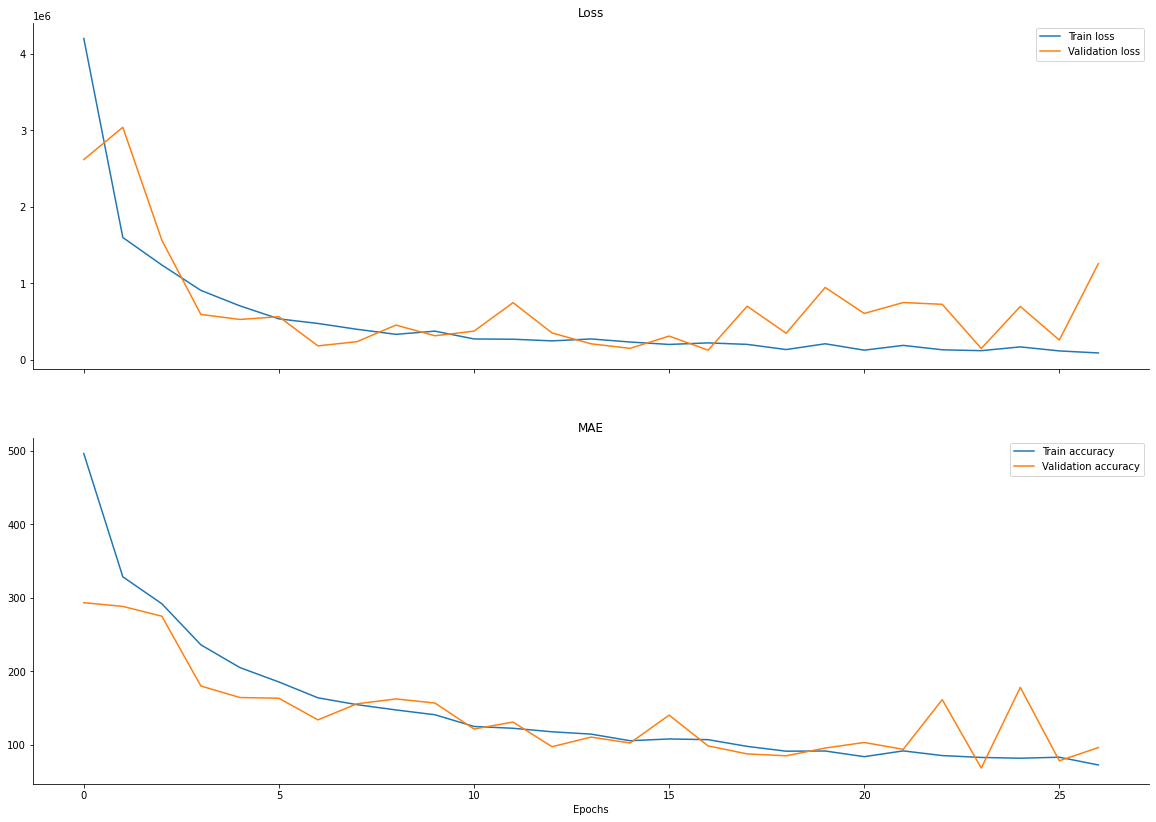

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Train accuracy')
ax2.plot(history['val_mae'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [32]:
model.load_weights('model.h5')
model.evaluate(test_ds)

1813/1813 [==============================] - 25s 14ms/step - loss: 123137.2344 - mae: 98.1022


[123137.234375, 98.10221099853516]

# Results

* MinMaxScalar:   loss: 349852.2500 - mae: 217.9379
* No scaling:     loss: 39541308.0000 - mae: 1853.0940
* RobustScaler:   loss: 2973207.7500 - mae: 192.8916
* StandardScaler: **loss: 42956.1250 - mae: 76.7915**
* deeper NN:      loss: 147935.1406 - mae: 126.3681
* thicker NN:     loss: 39153.5625 - mae: 78.8219
* new arch:       loss: 582790.4375 - mae: 286.8643

